In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
from numba import jit
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import os
import psutil
process = psutil.Process(os.getpid())

pd.set_option('display.max_columns', 500)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
files = []


for dirname, _, filenames in os.walk('../Data'):
    for filename in filenames:
        files.append(os.path.join(dirname, filename))
        

# from plotly import graph_objs as g
# import plotly.express as px
import seaborn as sns
import matplotlib.pylab as plt

import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
# Any results you write to the current directory are saved as output.

import altair as alt
from altair.vega import v5
from IPython.display import HTML

import time

RANDOM_SEED = 42


In [26]:
# using ideas from this kernel: https://www.kaggle.com/notslush/altair-visualization-2018-stackoverflow-survey
def prepare_altair():
    """
    Helper function to prepare altair for working.
    """

    vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v5.SCHEMA_VERSION
    vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
    vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
    vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
    noext = "?noext"
    
    paths = {
        'vega': vega_url + noext,
        'vega-lib': vega_lib_url + noext,
        'vega-lite': vega_lite_url + noext,
        'vega-embed': vega_embed_url + noext
    }
    
    workaround = f"""    requirejs.config({{
        baseUrl: 'https://cdn.jsdelivr.net/npm/',
        paths: {paths}
    }});
    """
    
    return workaround
    

def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay outside and 
    return wrapped
           

@add_autoincrement
def render(chart, id="vega-chart"):
    """
    Helper function to plot altair visualizations.
    """
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log("anything?");
    }});
    console.log("really...anything?");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )
    

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
    

@jit
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc


def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True


def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()
    


def train_model_classification(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000, splits=None, n_folds=3, averaging='usual', n_jobs=-1,groups = None):
    """
    A function to train a variety of classification models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    n_splits = folds.n_splits if splits is None else n_folds
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    if averaging == 'usual':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))
        
    elif averaging == 'rank':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))

    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y,groups)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = n_jobs)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)[:, 1]
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=n_estimators, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
#         if model_type == 'sklearn':
#             model = model
#             model.fit(X_train, y_train)
            
#             y_pred_valid = model.predict(X_valid).reshape(-1,)
#             score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
#             print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
#             print('')
            
#             y_pred = model.predict_proba(X_test)
        
#         if model_type == 'cat':
#             model = CatBoostClassifier(iterations=n_estimators, eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
#                                       loss_function=Logloss)
#             model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

#             y_pred_valid = model.predict(X_valid)
#             y_pred = model.predict(X_test)
        
        if averaging == 'usual':
            
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
            
            prediction += y_pred.reshape(-1, 1)

#         elif averaging == 'rank':
                                  
#             oof[valid_index] = y_pred_valid.reshape(-1, 1)
#             scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
                                  
#             prediction += pd.Series(y_pred).rank().values.reshape(-1, 1)        
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
            result_dict['top_columns'] = cols
        
    return result_dict

# setting up altair
workaround = prepare_altair()
HTML("".join((
    "<script>",
    workaround,
    "</script>",
)))

## Load files

In [3]:
folder_path = '../Data/'
train_id = pd.read_csv(f'{folder_path}train_identity.csv')
train_tr = pd.read_csv(f'{folder_path}train_transaction.csv')

test_id = pd.read_csv(f'{folder_path}test_identity.csv')
test_tr = pd.read_csv(f'{folder_path}test_transaction.csv')


## Explore the data

In [4]:
print('train_tr shape is {}'.format(train_tr.shape))
print('test_tr shape is {}'.format(test_tr.shape))
print('train_id shape is {}'.format(train_id.shape))
print('test_id shape is {}'.format(test_id.shape))

train_tr shape is (590540, 394)
test_tr shape is (506691, 393)
train_id shape is (144233, 41)
test_id shape is (141907, 41)


### Merge

In [5]:
# Merge the datasets
train = pd.merge(train_tr, train_id, on='TransactionID', how='left')
test = pd.merge(test_tr, test_id, on='TransactionID', how='left')

del train_tr, train_id, test_tr, test_id
gc.collect()

50

## Feature Engineering

In [6]:
# Standard normalization [-1,1] 
train['Trans_min_mean'] = train['TransactionAmt'] - train['TransactionAmt'].mean()
train['Trans_min_std'] = train['Trans_min_mean'] / train['TransactionAmt'].std()

test['Trans_min_mean'] = test['TransactionAmt'] - test['TransactionAmt'].mean()
test['Trans_min_std'] = test['Trans_min_mean'] / test['TransactionAmt'].std()

In [7]:
train['TransactionAmt_to_mean_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('std')

test['TransactionAmt_to_mean_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_std_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('std')

## Data Prep

In [8]:
import random, datetime
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    

## Add New Features

SEED = 42
seed_everything(SEED)
TARGET = 'isFraud'
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

def addNewFeatures(data): 
    data['uid'] = data['card1'].astype(str)+'_'+data['card2'].astype(str)

    data['uid2'] = data['uid'].astype(str)+'_'+data['card3'].astype(str)+'_'+data['card5'].astype(str)

    data['uid3'] = data['uid2'].astype(str)+'_'+data['addr1'].astype(str)+'_'+data['addr2'].astype(str)
    
    return data

train = addNewFeatures(train)
test = addNewFeatures(test)

i_cols = ['card1','card2','card3','card5','uid','uid2','uid3']

for col in i_cols:
    for agg_type in ['mean','std']:
        new_col_name = col+'_TransactionAmt_'+agg_type
        temp_df = pd.concat([train[[col, 'TransactionAmt']], test[[col,'TransactionAmt']]])
        temp_df['TransactionAmt'] = temp_df['TransactionAmt'].astype(int)
        temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})

        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   

        train[new_col_name] = train[col].map(temp_df)
        test[new_col_name]  = test[col].map(temp_df)

train = train.replace(np.inf,999)
test = test.replace(np.inf,999)

train['TransactionAmt'] = np.log1p(train['TransactionAmt'])
test['TransactionAmt'] = np.log1p(test['TransactionAmt'])

### Handle Email Domains

# As you may have noticed, for some companies there are several email addresses. For a better analysis we will consider them same as each other.

emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other',
          'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft',
          'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 
          'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other',
          'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo',
          'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo',
          'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo',
          'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo',
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other',
          'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple',
          'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other',
          'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

for c in ['P_emaildomain', 'R_emaildomain']:
    train[c + '_bin'] = train[c].map(emails)
    test[c + '_bin'] = test[c].map(emails)
    
    train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1])
    test[c + '_suffix'] = test[c].map(lambda x: str(x).split('.')[-1])
    
    train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test[c + '_suffix'] = test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

### Handle P Email Domain and R Email Domain

p = 'P_emaildomain'
r = 'R_emaildomain'
uknown = 'email_not_provided'

def setDomain(df):
    df[p] = df[p].fillna(uknown)
    df[r] = df[r].fillna(uknown)
    
    # Check if P_emaildomain matches R_emaildomain
    df['email_check'] = np.where((df[p]==df[r])&(df[p]!=uknown),1,0)

    df[p+'_prefix'] = df[p].apply(lambda x: x.split('.')[0])
    df[r+'_prefix'] = df[r].apply(lambda x: x.split('.')[0])
    
    return df
    
train=setDomain(train)
test=setDomain(test)

### Set Time

def setTime(df):
    df['TransactionDT'] = df['TransactionDT'].fillna(df['TransactionDT'].median())
    # Temporary
    df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
    df['DT_M'] = (df['DT'].dt.year-2017)*12 + df['DT'].dt.month
    df['DT_W'] = (df['DT'].dt.year-2017)*52 + df['DT'].dt.weekofyear
    df['DT_D'] = (df['DT'].dt.year-2017)*365 + df['DT'].dt.dayofyear
    
    df['DT_hour'] = df['DT'].dt.hour
    df['DT_day_week'] = df['DT'].dt.dayofweek
    df['DT_day'] = df['DT'].dt.day
    
    # Lets transform D8 and D9 column
    # As we almost sure it has connection with hours
    df['D9_not_na'] = np.where(df['D9'].isna(),0,1)
    df['D8_not_same_day'] = np.where(df['D8']>=1,1,0)
    df['D8_D9_decimal_dist'] = df['D8'].fillna(0)-df['D8'].fillna(0).astype(int)
    df['D8_D9_decimal_dist'] = ((df['D8_D9_decimal_dist']-df['D9'])**2)**0.5
    df['D8'] = df['D8'].fillna(-1).astype(int)

    return df
    
train=setTime(train)
test=setTime(test)

### Handle Browser Version

train["lastest_browser"] = np.zeros(train.shape[0])
test["lastest_browser"] = np.zeros(test.shape[0])

def setBrowser(df):
    df.loc[df["id_31"]=="samsung browser 7.0",'lastest_browser']=1
    df.loc[df["id_31"]=="opera 53.0",'lastest_browser']=1
    df.loc[df["id_31"]=="mobile safari 10.0",'lastest_browser']=1
    df.loc[df["id_31"]=="google search application 49.0",'lastest_browser']=1
    df.loc[df["id_31"]=="firefox 60.0",'lastest_browser']=1
    df.loc[df["id_31"]=="edge 17.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 69.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 67.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for ios",'lastest_browser']=1
    return df

train=setBrowser(train)
test=setBrowser(test)

### Handle Device Type

# We have the same issue with devices too.

def setDevice(df):
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    
    df['device_name'] = df['DeviceInfo'].str.split('/', expand=True)[0]

    df.loc[df['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    df.loc[df['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    df.loc[df['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    df.loc[df['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    df.loc[df['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    df.loc[df['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    df.loc[df.device_name.isin(df.device_name.value_counts()[df.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    df['had_id'] = 1
    gc.collect()
    
    return df

train=setDevice(train)
test=setDevice(test)

### Set Frequency

i_cols = ['card1','card2','card3','card5',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'D1','D2','D3','D4','D5','D6','D7','D8',
          'addr1','addr2',
          'dist1','dist2',
          'P_emaildomain', 'R_emaildomain',
          'DeviceInfo','device_name',
          'id_30','id_33',
          'uid','uid2','uid3',
         ]

for col in i_cols:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts(dropna=False).to_dict()   
    train[col+'_fq_enc'] = train[col].map(fq_encode)
    test[col+'_fq_enc']  = test[col].map(fq_encode)


# for col in ['DT_M','DT_W','DT_D']:
#     temp_df = pd.concat([train[[col]], test[[col]]])
#     fq_encode = temp_df[col].value_counts().to_dict()
            
#     train[col+'_total'] = train[col].map(fq_encode)
#     test[col+'_total']  = test[col].map(fq_encode)

# periods = ['DT_M','DT_W','DT_D']
# i_cols = ['uid']
# for period in periods:
#     for col in i_cols:
#         new_column = col + '_' + period
            
#         temp_df = pd.concat([train[[col,period]], test[[col,period]]])
#         temp_df[new_column] = temp_df[col].astype(str) + '_' + (temp_df[period]).astype(str)
#         fq_encode = temp_df[new_column].value_counts().to_dict()
            
#         train[new_column] = (train[col].astype(str) + '_' + train[period].astype(str)).map(fq_encode)
#         test[new_column]  = (test[col].astype(str) + '_' + test[period].astype(str)).map(fq_encode)
        
#         train[new_column] /= train[period+'_total']
#         test[new_column]  /= test[period+'_total']

In [9]:
noisy_cols = [
    'TransactionID','TransactionDT',                      # Not target in features))
    'uid','uid2','uid3',                                 
    'DT','DT_W','DT_D',       
    'DT_hour','DT_day_week','DT_day',
    'id_30','id_31','id_33',
    'D1', 'D2', 'D9',
]

# noisy_cols = list(train[noisy_cols].select_dtypes(include=['object']).columns) 

train = train.drop(noisy_cols, axis=1)
test = test.drop(noisy_cols, axis=1)

In [10]:
def get_too_many_null_attr(data):
    many_null_cols = [col for col in data.columns if data[col].isnull().sum() / data.shape[0] > 0.9]
    return many_null_cols

def get_too_many_repeated_val(data):
    big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
    return big_top_value_cols

def get_useless_columns(data):
    too_many_null = get_too_many_null_attr(data)
    print("More than 90% null: " + str(len(too_many_null)))
    too_many_repeated = get_too_many_repeated_val(data)
    print("More than 90% repeated value: " + str(len(too_many_repeated)))
    cols_to_drop = list(set(too_many_null + too_many_repeated))
    cols_to_drop.remove('isFraud')
    return cols_to_drop


cols_to_drop = get_useless_columns(train)

train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

More than 90% null: 12
More than 90% repeated value: 73


In [11]:
train.M1.head()

0      T
1    NaN
2      T
3    NaN
4    NaN
Name: M1, dtype: object

### Encode the categorical columns

In [12]:
test.M1.head()

0    T
1    T
2    T
3    T
4    T
Name: M1, dtype: object

In [13]:
train.head()

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D3,D4,D5,D6,D8,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V302,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_32,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,Trans_min_mean,Trans_min_std,TransactionAmt_to_mean_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card1,TransactionAmt_to_std_card4,card1_TransactionAmt_mean,card1_TransactionAmt_std,card2_TransactionAmt_mean,card2_TransactionAmt_std,card3_TransactionAmt_mean,card3_TransactionAmt_std,card5_TransactionAmt_mean,card5_TransactionAmt_std,uid_TransactionAmt_mean,uid_TransactionAmt_std,uid2_TransactionAmt_mean,uid2_TransactionAmt_std,uid3_TransactionAmt_mean,uid3_TransactionAmt_std,P_emaildomain_bin,P_emaildomain_suffix,R_emaildomain_bin,R_emaildomain_suffix,email_check,P_emaildomain_prefix,R_emaildomain_prefix,DT_M,D9_not_na,D8_D9_decimal_dist,device_name,card1_fq_enc,card2_fq_enc,card3_fq_enc,card5_fq_enc,C1_fq_enc,C2_fq_enc,C4_fq_enc,C5_fq_enc,C6_fq_enc,C7_fq_enc,C8_fq_enc,C9_fq_enc,C10_fq_enc,C11_fq_enc,C12_fq_enc,C13_fq_enc,C14_fq_enc,D1_fq_enc,D2_fq_enc,D3_fq_enc,D4_fq_enc,D5_fq_enc,D6_fq_enc,D8_fq_enc,addr1_fq_enc,addr2_fq_enc,dist1_fq_enc,P_emaildomain_fq_enc,R_emaildomain_fq_enc,DeviceInfo_fq_enc,device_name_fq_enc,id_30_fq_enc,id_33_fq_enc,uid_fq_enc,uid2_fq_enc,uid3_fq_enc
0,0,4.241327,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,email_not_provided,email_not_provided,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,13.0,NaN,NaN,NaN,-1,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [14]:
# cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
#             'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
#             'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9',
#             'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']
cat_cols = list(train.select_dtypes(include=['object']).columns)
for col in cat_cols:
    if col in train.columns:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))   

## Make train and test sets 

In [15]:
noisy_cols

['TransactionID',
 'TransactionDT',
 'uid',
 'uid2',
 'uid3',
 'DT',
 'DT_W',
 'DT_D',
 'DT_hour',
 'DT_day_week',
 'DT_day',
 'id_30',
 'id_31',
 'id_33',
 'D1',
 'D2',
 'D9']

In [16]:
# sample_size = 10000
sample_size = None
if sample_size is not None:
    train_sample = train.sample(sample_size, random_state=42)
    test_sample = test.sample(sample_size, random_state=42)
else:
    train_sample = train
    test_sample = test

In [17]:
X = train_sample.drop(['isFraud'], axis=1)
y = train_sample['isFraud']
#X_test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)
X_test = test_sample
# del train, test
# test = test[["TransactionDT", 'TransactionID']]

### Remove infinite values

In [18]:
def clean_inf_nan(df):
    print(df[df.isna().any(axis=1)])
    return df.replace([np.inf, -np.inf], 999)   

# Cleaning infinite values to NaN
X = clean_inf_nan(X)
X_test = clean_inf_nan(X_test)

        TransactionAmt  ProductCD  card1  card2  card3  card4  card5  card6  \
0             4.241327          4  13926    NaN  150.0      1  142.0      1   
1             3.401197          4   2755  404.0  150.0      2  102.0      1   
2             4.094345          4   4663  490.0  150.0      4  166.0      2   
3             3.931826          4  18132  567.0  150.0      2  117.0      2   
4             3.931826          1   4497  514.0  150.0      2  102.0      1   
5             3.912023          4   5937  555.0  150.0      4  226.0      2   
6             5.075174          4  12308  360.0  150.0      4  166.0      2   
7             6.048554          4  12695  490.0  150.0      4  226.0      2   
8             2.772589          1   2803  100.0  150.0      4  226.0      2   
9             4.770685          4  17399  111.0  150.0      2  224.0      2   
10            4.342337          0  16496  352.0  117.0      2  134.0      1   
11            2.861915          0   4461  375.0  185

        TransactionAmt  ProductCD  card1  card2  card3  card4  card5  card6  \
0             3.494991          4  10409  111.0  150.0      4  226.0      2   
1             3.912023          4   4272  111.0  150.0      4  226.0      2   
2             5.147494          4   4476  574.0  150.0      4  226.0      2   
3             5.655817          4  10989  360.0  150.0      4  166.0      2   
4             4.233382          4  18018  452.0  150.0      2  117.0      2   
5             4.076690          4  12839  321.0  150.0      4  226.0      2   
6             4.477337          4  16560  476.0  150.0      4  126.0      2   
7             5.968708          4  15066  170.0  150.0      2  102.0      1   
8             4.653484          4   2803  100.0  150.0      4  226.0      2   
9             4.770685          4  12544  321.0  150.0      4  226.0      2   
10            5.571964          4  16982  127.0  150.0      2  224.0      2   
11            4.690889          4   9500  321.0  150

In [19]:
gc.collect()

34

## Train

In [20]:
# n_fold = 5
# folds = TimeSeriesSplit(n_splits=n_fold)
# folds = KFold(n_splits=5)
folds = GroupKFold(n_splits=6)
split_groups = X['DT_M']

{'num_leaves': 256, 'min_child_samples': 79, 'objective': 'binary', 'max_depth': 20, 'learning_rate': 0.03, 'boosting_type': 'gbdt', 'subsample_freq': 3, 'subsample': 0.9, 'bagging_seed': 11, 'metric': 'auc', 'verbosity': -1, 'reg_alpha': 0.3, 'reg_lambda': 0.3, 'colsample_bytree': 0.9}
Fold 1 started at Wed Oct  2 09:51:38 2019
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.999027	training's auc: 0.999027	valid_1's auc: 0.914356	valid_1's auc: 0.914356
Early stopping, best iteration is:
[745]	training's auc: 0.999864	training's auc: 0.999864	valid_1's auc: 0.914794	valid_1's auc: 0.914794
Fold 2 started at Wed Oct  2 09:57:57 2019
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.99908	training's auc: 0.99908	valid_1's auc: 0.942874	valid_1's auc: 0.942874
Early stopping, best iteration is:
[452]	training's auc: 0.998663	training's auc: 0.998663	valid_1's auc: 0.943048	valid_1's auc: 0.943048
Fold 3 started at 

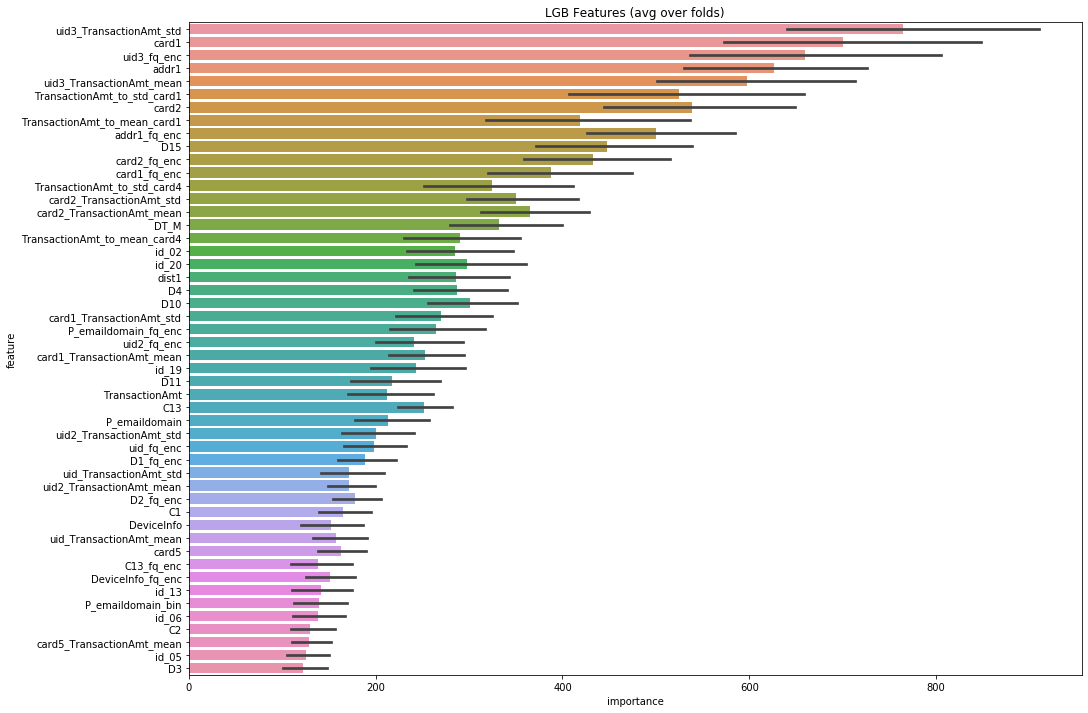

In [27]:
params = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 20, # Depth of the tree
          'learning_rate': 0.03,
          "boosting_type": "gbdt", # traditional Gradient Boosting Decision Tree
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          #'categorical_feature': cat_cols
         }
print(params)
result_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging='usual', n_jobs=-1,groups =split_groups)
sample_submission = pd.read_csv('../Data/sample_submission.csv')
sample_submission['isFraud'] = result_dict_lgb['prediction']
sample_submission.to_csv('submission_t2.csv', index=False)

{'num_leaves': 256, 'min_child_samples': 79, 'objective': 'binary', 'max_depth': 20, 'learning_rate': 0.03, 'boosting_type': 'gbdt', 'subsample_freq': 3, 'subsample': 0.9, 'bagging_seed': 11, 'metric': 'auc', 'verbosity': -1, 'reg_alpha': 0.3, 'reg_lambda': 0.3, 'colsample_bytree': 0.9}
Fold 1 started at Tue Oct  1 23:32:59 2019
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.999027	training's auc: 0.999027	valid_1's auc: 0.914356	valid_1's auc: 0.914356
Early stopping, best iteration is:
[745]	training's auc: 0.999864	training's auc: 0.999864	valid_1's auc: 0.914794	valid_1's auc: 0.914794
Fold 2 started at Tue Oct  1 23:39:52 2019
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.99908	training's auc: 0.99908	valid_1's auc: 0.942874	valid_1's auc: 0.942874
Early stopping, best iteration is:
[452]	training's auc: 0.998663	training's auc: 0.998663	valid_1's auc: 0.943048	valid_1's auc: 0.943048
Fold 3 started at 

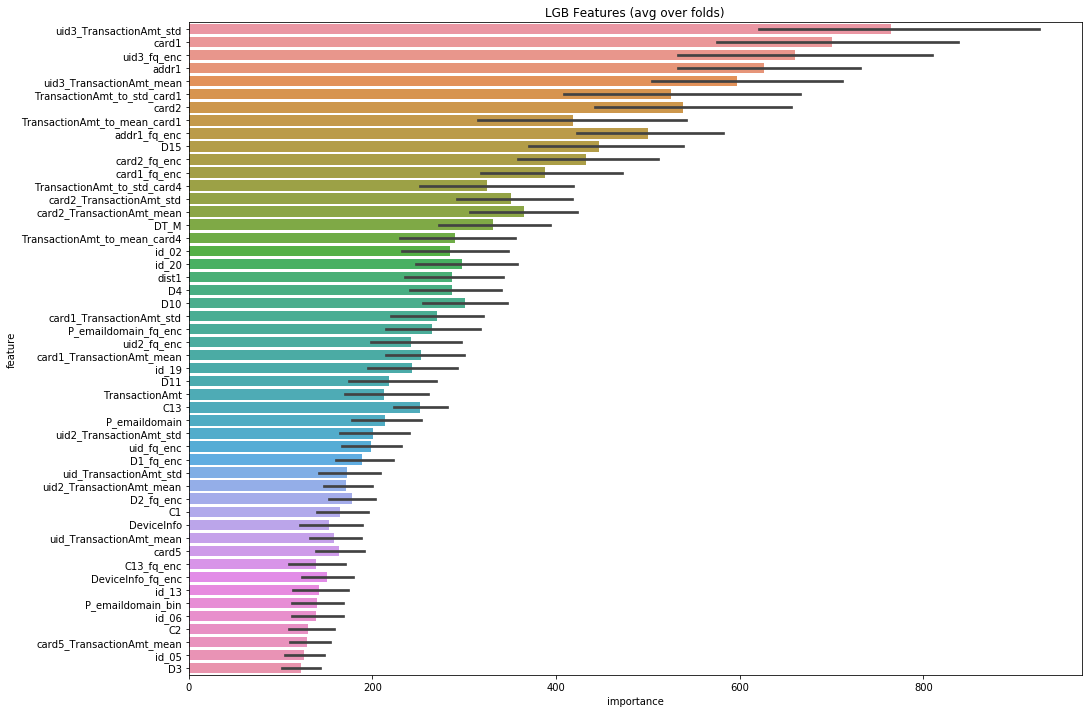

In [363]:
params = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 20, # Depth of the tree
          'learning_rate': 0.03,
          "boosting_type": "gbdt", # traditional Gradient Boosting Decision Tree
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          #'categorical_feature': cat_cols
         }
print(params)
result_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging='usual', n_jobs=-1,groups =split_groups)

Fold 1 started at Tue Oct  1 21:59:13 2019
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.997407	training's auc: 0.997407	valid_1's auc: 0.91291	valid_1's auc: 0.91291
Early stopping, best iteration is:
[512]	training's auc: 0.997533	training's auc: 0.997533	valid_1's auc: 0.913227	valid_1's auc: 0.913227
Fold 2 started at Tue Oct  1 22:03:59 2019
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.997423	training's auc: 0.997423	valid_1's auc: 0.94221	valid_1's auc: 0.94221
Early stopping, best iteration is:
[498]	training's auc: 0.997404	training's auc: 0.997404	valid_1's auc: 0.942247	valid_1's auc: 0.942247
Fold 3 started at Tue Oct  1 22:08:36 2019
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.996641	training's auc: 0.996641	valid_1's auc: 0.937865	valid_1's auc: 0.937865
[1000]	training's auc: 0.999853	training's auc: 0.999853	valid_1's auc: 0.93945	valid_1's auc: 0.93

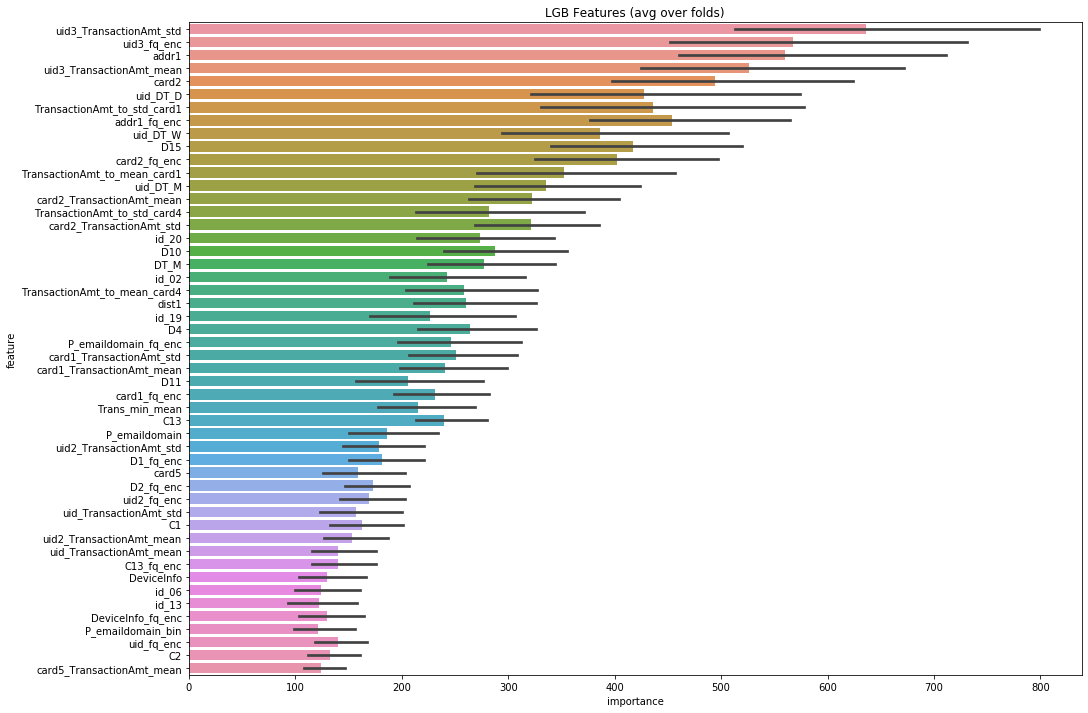

In [264]:
# submitted file
params = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 13, # Depth of the tree
          'learning_rate': 0.03,
          "boosting_type": "gbdt", # traditional Gradient Boosting Decision Tree
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          #'categorical_feature': cat_cols
         }
result_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging='usual', n_jobs=-1,groups =split_groups)

## Prev. Results

Fold 1 started at Tue Oct  1 16:49:35 2019
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.996247	training's auc: 0.996247	valid_1's auc: 0.910126	valid_1's auc: 0.910126
Early stopping, best iteration is:
[489]	training's auc: 0.99604	training's auc: 0.99604	valid_1's auc: 0.910281	valid_1's auc: 0.910281
Fold 2 started at Tue Oct  1 16:53:42 2019
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.996585	training's auc: 0.996585	valid_1's auc: 0.939399	valid_1's auc: 0.939399
Early stopping, best iteration is:
[437]	training's auc: 0.995333	training's auc: 0.995333	valid_1's auc: 0.939672	valid_1's auc: 0.939672
Fold 3 started at Tue Oct  1 16:57:41 2019
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.995922	training's auc: 0.995922	valid_1's auc: 0.936144	valid_1's auc: 0.936144
[1000]	training's auc: 0.999657	training's auc: 0.999657	valid_1's auc: 0.936757	valid_1's auc: 0

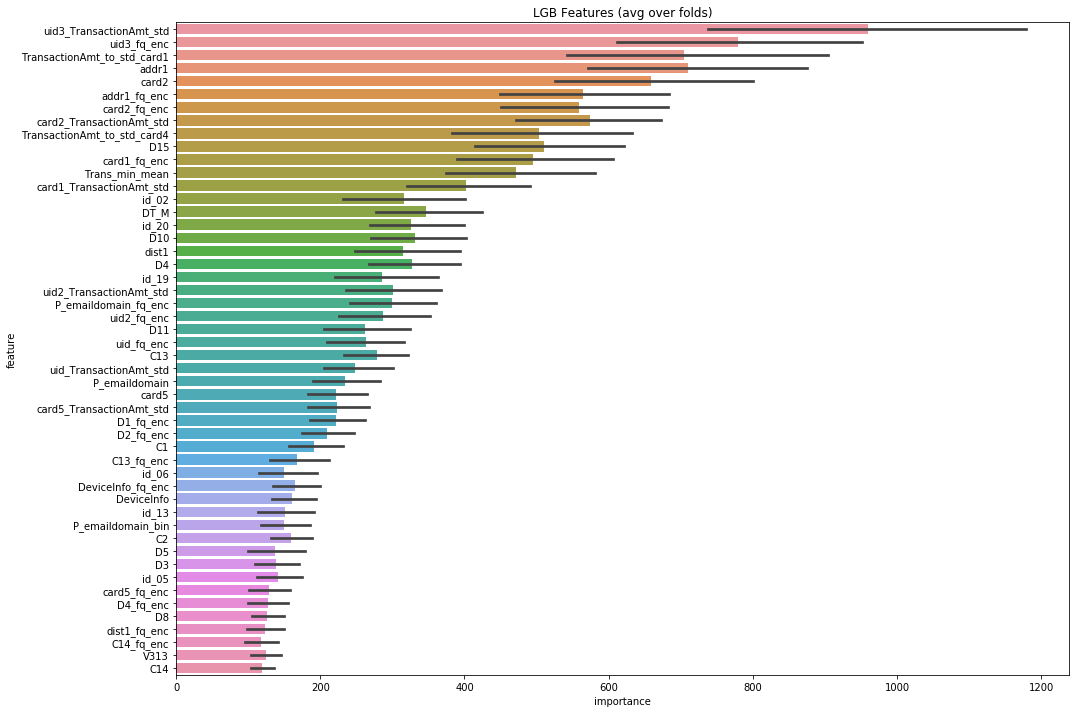

In [229]:
#Added back std, deleted mean per card, deleted freq related to dt and dropped card1,still no amount feature
params = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 13, # Depth of the tree
          'learning_rate': 0.03,
          "boosting_type": "gbdt", # traditional Gradient Boosting Decision Tree
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          #'categorical_feature': cat_cols
         }
result_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging='usual', n_jobs=-1,groups =split_groups)

Fold 1 started at Tue Oct  1 14:35:38 2019
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.996	training's auc: 0.996	valid_1's auc: 0.911682	valid_1's auc: 0.911682
Early stopping, best iteration is:
[480]	training's auc: 0.995617	training's auc: 0.995617	valid_1's auc: 0.911874	valid_1's auc: 0.911874
Fold 2 started at Tue Oct  1 14:39:34 2019
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.99653	training's auc: 0.99653	valid_1's auc: 0.937848	valid_1's auc: 0.937848
Early stopping, best iteration is:
[448]	training's auc: 0.995305	training's auc: 0.995305	valid_1's auc: 0.938359	valid_1's auc: 0.938359
Fold 3 started at Tue Oct  1 14:43:25 2019
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.995884	training's auc: 0.995884	valid_1's auc: 0.936385	valid_1's auc: 0.936385
Early stopping, best iteration is:
[727]	training's auc: 0.998682	training's auc: 0.998682	valid_1's au

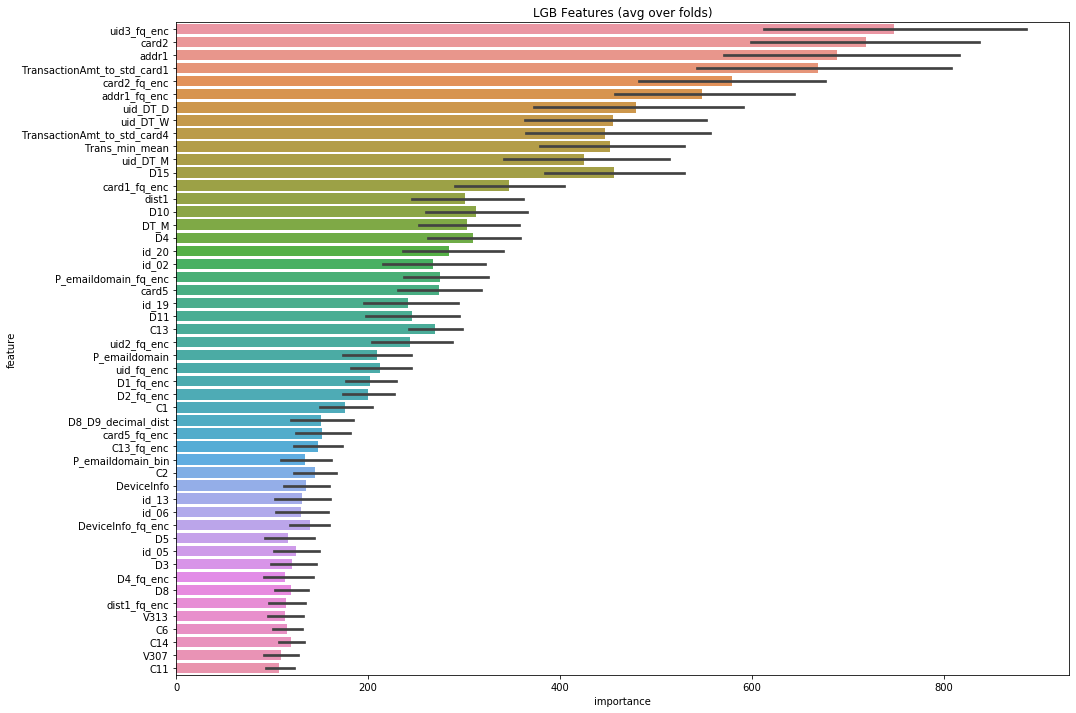

In [194]:
#Added back std per card and dropped card1,still no amount feature
params = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 13, # Depth of the tree
          'learning_rate': 0.03,
          "boosting_type": "gbdt", # traditional Gradient Boosting Decision Tree
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          #'categorical_feature': cat_cols
         }
result_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging='usual', n_jobs=-1,groups =split_groups)

Fold 1 started at Tue Oct  1 13:51:48 2019
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.994683	training's auc: 0.994683	valid_1's auc: 0.905226	valid_1's auc: 0.905226
Early stopping, best iteration is:
[396]	training's auc: 0.991895	training's auc: 0.991895	valid_1's auc: 0.905542	valid_1's auc: 0.905542
Fold 2 started at Tue Oct  1 13:55:12 2019
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.995237	training's auc: 0.995237	valid_1's auc: 0.935895	valid_1's auc: 0.935895
Early stopping, best iteration is:
[500]	training's auc: 0.995237	training's auc: 0.995237	valid_1's auc: 0.935895	valid_1's auc: 0.935895
Fold 3 started at Tue Oct  1 13:59:07 2019
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.994904	training's auc: 0.994904	valid_1's auc: 0.931702	valid_1's auc: 0.931702
Early stopping, best iteration is:
[632]	training's auc: 0.997229	training's auc: 0.997229	vali

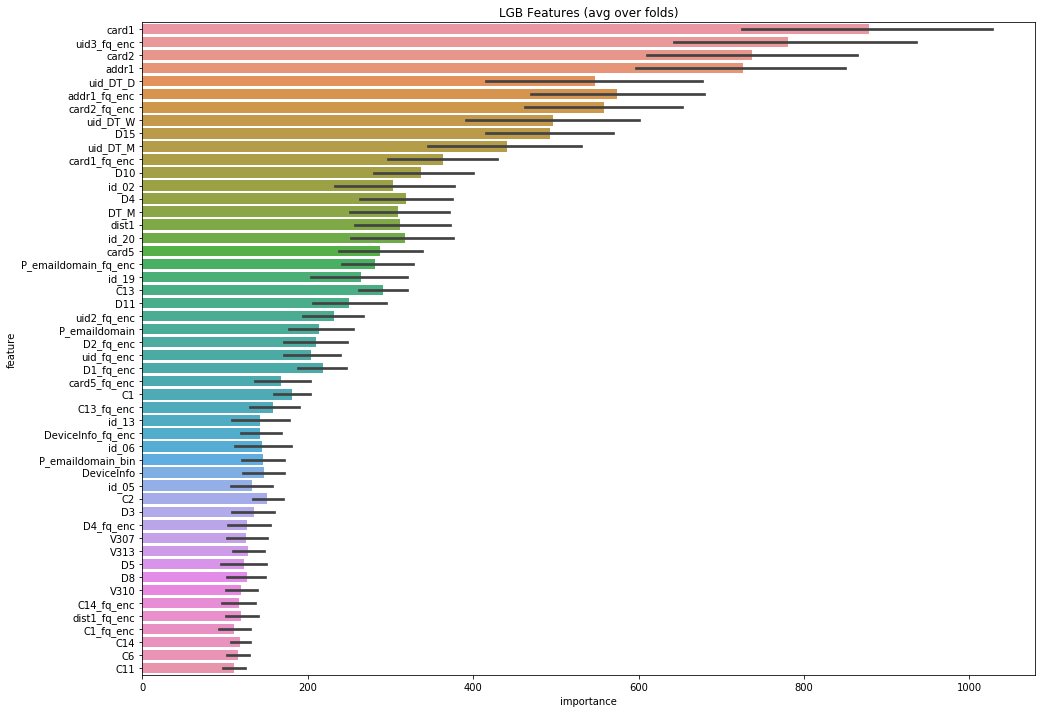

In [164]:
#Drop Amountstd too as only change after the one below (NaN -> 999)
params = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 13, # Depth of the tree
          'learning_rate': 0.03,
          "boosting_type": "gbdt", # traditional Gradient Boosting Decision Tree
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          #'categorical_feature': cat_cols
         }
result_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging='usual', n_jobs=-1,groups =split_groups)

Fold 1 started at Tue Oct  1 11:48:06 2019
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.99719	training's auc: 0.99719	valid_1's auc: 0.912848	valid_1's auc: 0.912848
Early stopping, best iteration is:
[482]	training's auc: 0.996892	training's auc: 0.996892	valid_1's auc: 0.912993	valid_1's auc: 0.912993
Fold 2 started at Tue Oct  1 11:52:15 2019
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.997537	training's auc: 0.997537	valid_1's auc: 0.941496	valid_1's auc: 0.941496
Early stopping, best iteration is:
[498]	training's auc: 0.997505	training's auc: 0.997505	valid_1's auc: 0.941501	valid_1's auc: 0.941501
Fold 3 started at Tue Oct  1 11:56:30 2019
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.996756	training's auc: 0.996756	valid_1's auc: 0.937206	valid_1's auc: 0.937206
[1000]	training's auc: 0.999866	training's auc: 0.999866	valid_1's auc: 0.939407	valid_1's auc: 0

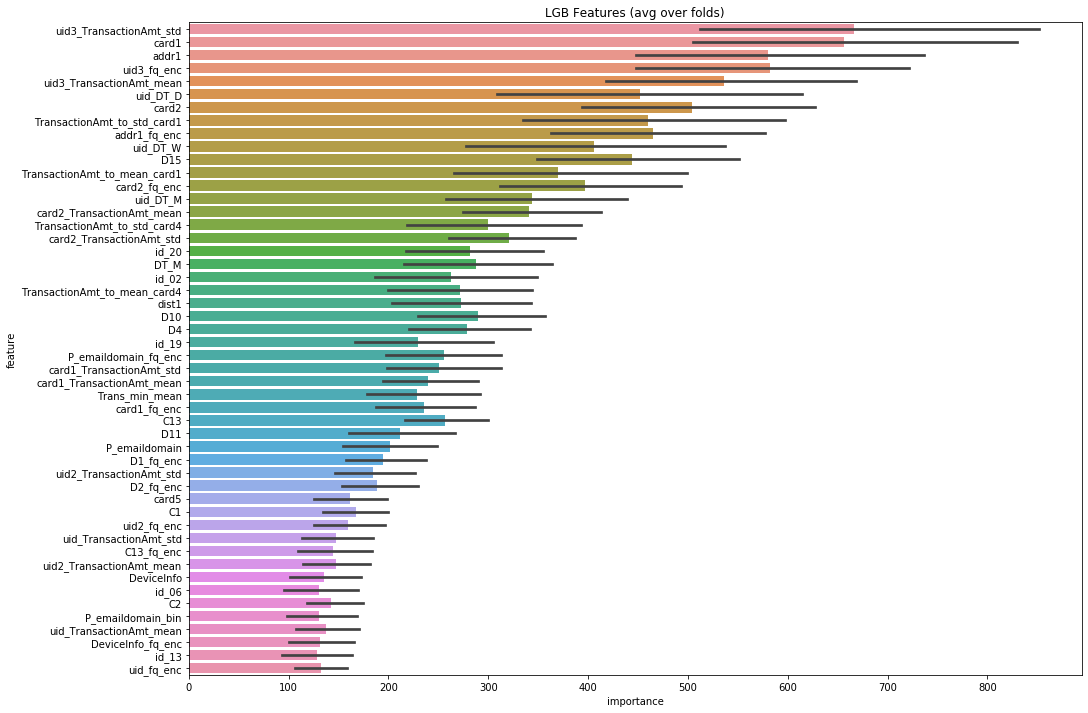

In [110]:
#Drop Amount as only change after the one below (NaN -> 999)
params = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 13, # Depth of the tree
          'learning_rate': 0.03,
          "boosting_type": "gbdt", # traditional Gradient Boosting Decision Tree
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          #'categorical_feature': cat_cols
         }
result_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging='usual', n_jobs=-1,groups =split_groups)

Fold 1 started at Tue Oct  1 11:09:49 2019
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.997209	training's auc: 0.997209	valid_1's auc: 0.911042	valid_1's auc: 0.911042
Early stopping, best iteration is:
[483]	training's auc: 0.996942	training's auc: 0.996942	valid_1's auc: 0.911574	valid_1's auc: 0.911574
Fold 2 started at Tue Oct  1 11:13:53 2019
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.997583	training's auc: 0.997583	valid_1's auc: 0.94133	valid_1's auc: 0.94133
Early stopping, best iteration is:
[499]	training's auc: 0.997574	training's auc: 0.997574	valid_1's auc: 0.941343	valid_1's auc: 0.941343
Fold 3 started at Tue Oct  1 11:18:07 2019
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.996811	training's auc: 0.996811	valid_1's auc: 0.937833	valid_1's auc: 0.937833
[1000]	training's auc: 0.999868	training's auc: 0.999868	valid_1's auc: 0.938843	valid_1's auc: 0

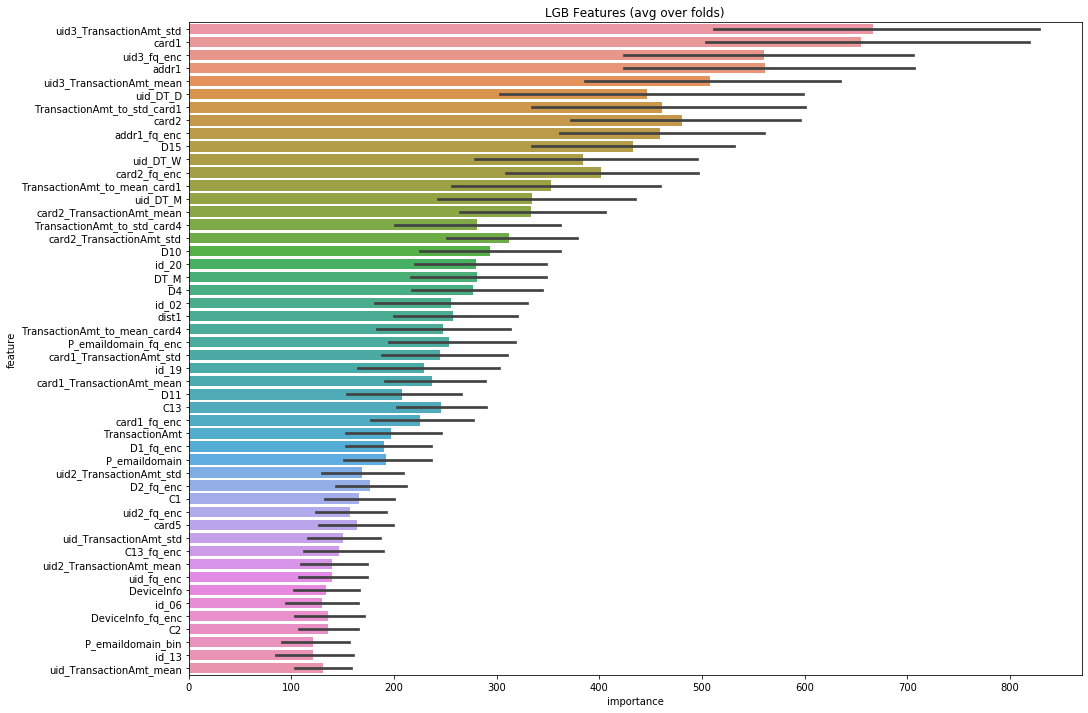

In [85]:
#Group kfold as only change after the one below (NaN -> 999)
params = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 13, # Depth of the tree
          'learning_rate': 0.03,
          "boosting_type": "gbdt", # traditional Gradient Boosting Decision Tree
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          #'categorical_feature': cat_cols
         }
result_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging='usual', n_jobs=-1,groups =split_groups)

Fold 1 started at Tue Oct  1 10:43:14 2019
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.996885	training's auc: 0.996885	valid_1's auc: 0.919728	valid_1's auc: 0.919728
Early stopping, best iteration is:
[480]	training's auc: 0.996574	training's auc: 0.996574	valid_1's auc: 0.919862	valid_1's auc: 0.919862
Fold 2 started at Tue Oct  1 10:47:29 2019
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.99734	training's auc: 0.99734	valid_1's auc: 0.937086	valid_1's auc: 0.937086
Early stopping, best iteration is:
[431]	training's auc: 0.996105	training's auc: 0.996105	valid_1's auc: 0.937421	valid_1's auc: 0.937421
Fold 3 started at Tue Oct  1 10:51:13 2019
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.997238	training's auc: 0.997238	valid_1's auc: 0.934403	valid_1's auc: 0.934403
Early stopping, best iteration is:
[379]	training's auc: 0.994643	training's auc: 0.994643	valid_

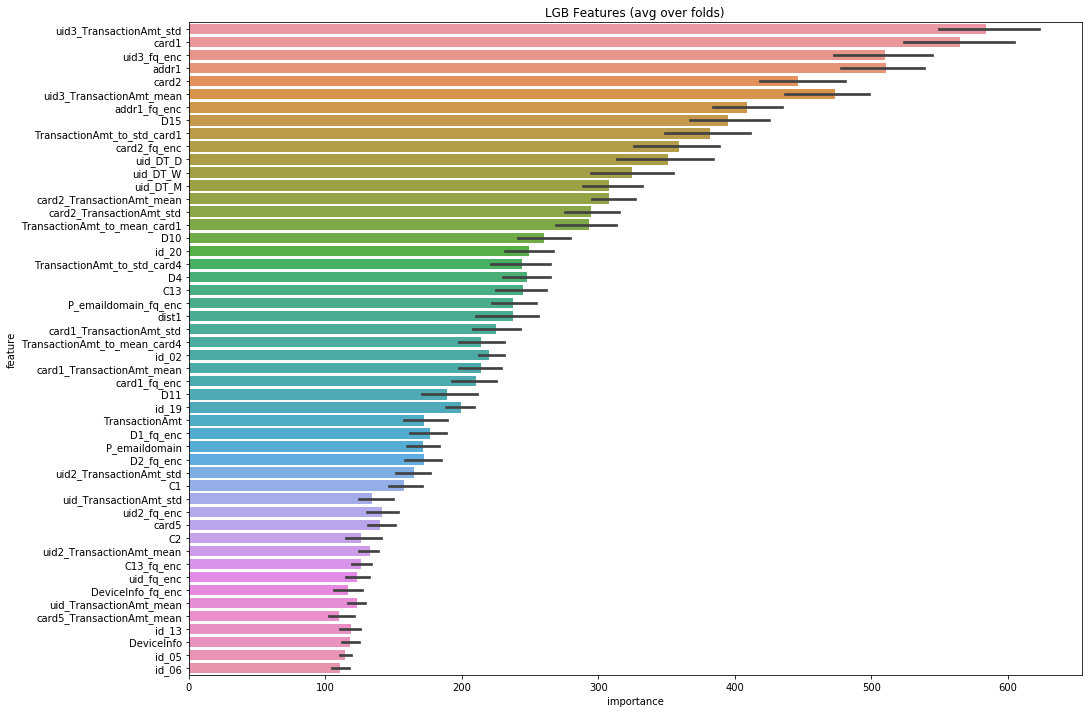

In [65]:
params = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 13, # Depth of the tree
          'learning_rate': 0.03,
          "boosting_type": "gbdt", # traditional Gradient Boosting Decision Tree
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          #'categorical_feature': cat_cols
         }
result_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging='usual', n_jobs=-1)

In [265]:
result_dict_lgb['prediction']

array([[0.00086951],
       [0.0017939 ],
       [0.00058283],
       ...,
       [0.00865063],
       [0.00503724],
       [0.00316707]])

In [364]:
sample_submission = pd.read_csv('../Data/sample_submission.csv')

In [267]:
sample_submission.head()

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5


In [365]:
sample_submission['isFraud'] = result_dict_lgb['prediction']
sample_submission.to_csv('submission_t.csv', index=False)

In [269]:
sample_submission.head()

,TransactionID,isFraud
0,3663549,0.000870
1,3663550,0.001794
2,3663551,0.000583
3,3663552,0.001281
4,3663553,0.000978
